In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import Imputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


In [99]:
# Sets seaborn "theme"
sns.set_style('whitegrid')

# Gets and filters training data.
wanted_columns = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
data = pd.read_csv('train.csv', usecols=wanted_columns)
data = data.set_index('PassengerId')

# Gets and filters testing data.
wanted_test_columns = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
test_data = pd.read_csv('test.csv', usecols=wanted_test_columns)
test_data_indexes = test_data['PassengerId']
test_data = test_data.set_index('PassengerId')

# Gets Y axis data.
data_y = data['Survived']
data_X = data.drop('Survived', axis=1)


In [100]:
# Handles preprocessing

def preprocess(train_X, test_X):
    # Deals with NaN data containing rows.
    imputer = Imputer()
    NaN_containing_rows = ['Age', 'Fare']
    train_X[NaN_containing_rows] = imputer.fit_transform(train_X[NaN_containing_rows])
    test_X[NaN_containing_rows] = imputer.transform(test_X[NaN_containing_rows])
    
    # Uses log on skewed features to improve performance.
    scaler = MinMaxScaler()
    skewed = ['Fare']
    train_X[skewed] = train_X[skewed].apply(lambda x: np.log(x + 1))
    test_X[skewed] = test_X[skewed].apply(lambda x: np.log(x + 1))
    
    # Normalizes continuous features.
    continuous = ['Age', 'Fare']
    train_X[continuous] = scaler.fit_transform(train_X[continuous])
    test_X[continuous] = scaler.transform(test_X[continuous])
    
    # One hot encodes categorical features.
    categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked']
    train_X = pd.get_dummies(train_X, columns=categorical)
    test_X = pd.get_dummies(test_X, columns=categorical)
    
    # Handles with the different number of features.
    missing_cols = set(train_X) - set(test_X)
    for col in missing_cols:
        test_X[col] = 0
    test_X = test_X[train_X.columns]
    
    return train_X, test_X
   


In [160]:
train_X, test_X = preprocess(data_X, test_data)

# Splits train and test data to get model accuracy.
X_train, X_test, y_train, y_test = train_test_split(train_X, data_y, test_size=0.15)

# Instantiates the models.
dtc_model = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=3, max_depth=15, criterion='entropy')
lr_model = LogisticRegression()
ada_model = AdaBoostClassifier(base_estimator=dtc_model)
rf_model = RandomForestClassifier(criterion='entropy', n_estimators=150)
gb_model = GradientBoostingClassifier()

# Maps the models into an array of dictionaries with an attribute "name".
models = [{'obj': dtc_model, 'name': 'DecisionTree'}, 
          {'obj': lr_model, 'name': 'LogisticRegression'}, 
          {'obj': ada_model, 'name': 'AdaBoost'},
          {'obj': rf_model, 'name': 'RandomForest'},
          {'obj': gb_model, 'name': 'GradientBoost'}]


In [161]:
# Outputs the result in a csv file.
def output_csv(prediction, name):
    now = str(int(datetime.datetime.now().timestamp()))
    dictionary = {"Survived": prediction, "PassengerId": test_data_indexes}
    prediction_df = pd.DataFrame(dictionary)
    prediction_df.to_csv(name + now + '.csv', index=False)


In [162]:
# Function to fit, predict and get accuracy of the different models.
def fit_predict_get_accuracy(model_obj, X_train, y_train, X_test, y_test, name, index):
    start = time.time()
    model_obj.fit(X_train, y_train)    
    
    prediction = model_obj.predict(X_test)
    prediction_accuracy_score = accuracy_score(y_test, prediction)
    prediction_f1_score = f1_score(y_test, prediction)
    
    end = time.time()
    
    models[index]['accuracy_score'] = prediction_accuracy_score
    models[index]['f1_score'] = prediction_f1_score
    models[index]['time'] = end - start

    return np.mean([prediction_accuracy_score, prediction_f1_score])
    


In [163]:
def display_plots():
    
    models_df = pd.DataFrame(models)
    
    plt.figure(figsize=(15,8))
    sns.barplot(x=models_df['name'], y=models_df['accuracy_score'])
    plt.figure(figsize=(15,8))
    sns.barplot(x=models_df['name'], y=models_df['f1_score'])
    plt.figure(figsize=(15,8))
    sns.barplot(x=models_df['name'], y=models_df['time'])
    

The winner is: DecisionTree!!!


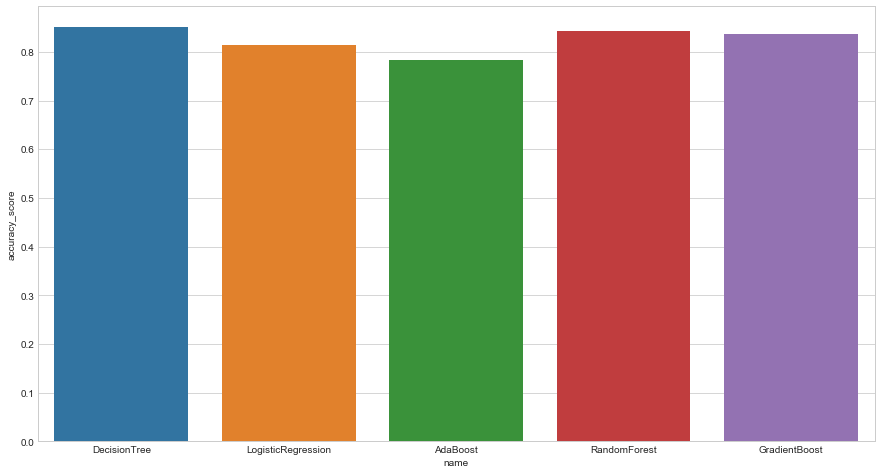

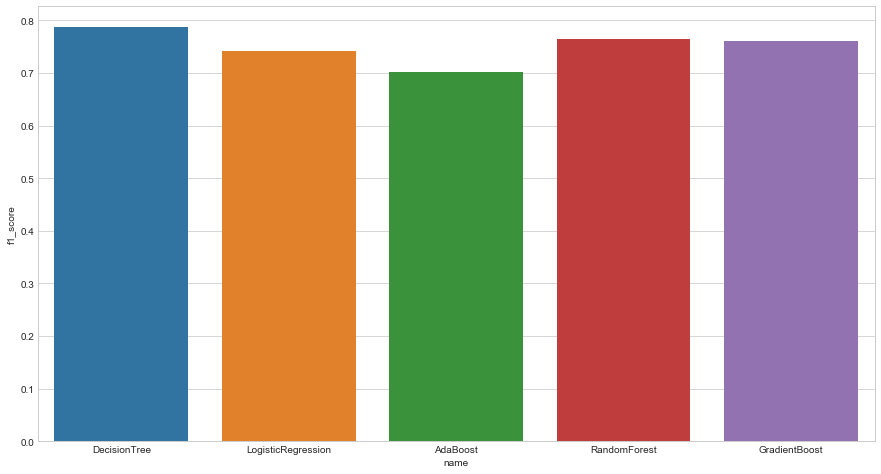

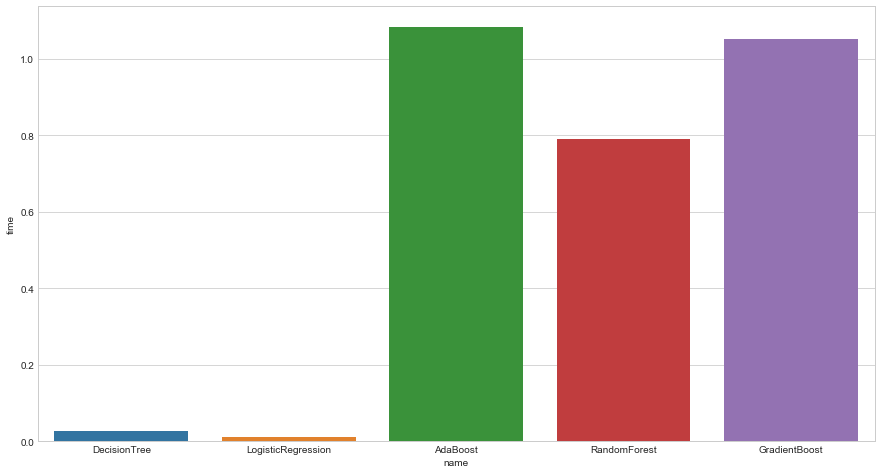

In [164]:
# Executes the function in each model, gets the best of them and outputs a csv file.
scores = []
for index, model in enumerate(models):
    scores.append(fit_predict_get_accuracy(model['obj'], X_train, y_train, X_test, y_test, model['name'], index))
    
max_score = max(scores)
max_score_index = scores.index(max_score)
best_model = models[max_score_index]

display_plots()

bm_prediction = best_model['obj'].predict(test_X)
output_csv(bm_prediction, best_model['name'])

print("The winner is: {}!!!".format(best_model['name']))